# Experimento 1
***
- Conjuntos de dados: Montgomery + Shenzen
- Testando a equalização de histograma em comparação com a mudança típica de escala

### Importando os pacotes necessários

In [15]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import urllib.request
import pandas as pd
import numpy as np
import glob
import re

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf

### Pré-processamento dos Dados

In [4]:
filelist_shenzen = glob.glob('/content/drive/MyDrive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/*.png')
filelist_montgomery = glob.glob('/content/drive/MyDrive/Montgomery/MontgomerySet/CXR_png/*.png')
filelist = filelist_shenzen + filelist_montgomery

print('quantidade de imagens:', str(len(filelist)))

quantidade de imagens: 800


In [5]:
def extract_label(file_list):
    '''
    extraindo os rótulos do conjunto de imagens

    Args:
        file_list (list) --> lista dos arquivos do conjunto de imagens
    
    Returns:
        labels (list) --> lista dos rótulos do conjunto de imagens
    '''
    
    labels = []
    for file in tqdm(file_list):
        current_label = re.findall('[0-9]{4}_(.+?).png', file)
        labels.append(current_label[0])
        
    return labels

In [7]:
labels = extract_label(filelist)
print('quantidade de rótulos:', str(len(labels)))

quantidade de rótulos: 800


In [12]:
full_data = pd.DataFrame(filelist, columns = ['filepath'])
full_data['target'] = labels
dict_type = {'target': 'float32'}
full_data = full_data.astype(dict_type)

train_df, test_df = train_test_split(full_data, stratify = full_data['target'], test_size = 0.2, random_state = 42)
train_df, validation_df = train_test_split(train_df, stratify = train_df['target'], test_size = 0.2, random_state = 42)

print('quantidade de imagens de treinamento:', len(train_df['filepath']))
print('quantidade de rótulos de treinamento:', len(train_df['target']))
print('quantidade de imagens de teste:', len(test_df['filepath']))
print('quantidade de rótulos de teste:', len(test_df['target']))
print('quantidade de imagens de validação:', len(validation_df['filepath']))
print('quantidade de rótulos de validação:', len(validation_df['target']))

quantidade de imagens de treinamento: 512
quantidade de rótulos de treinamento: 512
quantidade de imagens de teste: 160
quantidade de rótulos de teste: 160
quantidade de imagens de validação: 128
quantidade de rótulos de validação: 128


### Aplicando equalização de histograma

In [13]:
image_generator = ImageDataGenerator(samplewise_center = True, samplewise_std_normalization = True,
                                     rotation_range = 10, zoom_range = 0.2)

train_generator = image_generator.flow_from_dataframe(dataframe = train_df, directory = '', x_col = 'filepath',
                                                      y_col = 'target', batch_size = 32, seed = 42,
                                                      shuffle = True, class_mode = 'raw', color_mode = 'rgb',
                                                      target_size = (256, 256))

valid_generator = image_generator.flow_from_dataframe(dataframe = validation_df, directory = '.', x_col = 'filepath',
                                                      y_col = 'target', batch_size = 32, seed = 42,
                                                      shuffle = True, class_mode = 'raw', target_size = (256, 256))

test_datagen = ImageDataGenerator(samplewise_center = True, samplewise_std_normalization = True)

test_generator = test_datagen.flow_from_dataframe(dataframe = test_df, directory = '.', x_col = 'filepath',
                                                  y_col = 'target', batch_size = 32, seed = 42,
                                                  shuffle = True, class_mode = 'raw', target_size = (256, 256))

Found 512 validated image filenames.
Found 128 validated image filenames.
Found 160 validated image filenames.


### Preparando a rede neural convolucional

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [ ]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (256, 256, 3), include_top = False, weights = None)
pre_trained_model.load_weights(local_weights_file)
 
pre_trained_model.trainable, set_trainable = True, False

for layer in pre_trained_model.layers:
    if layer.name == 'mixed6':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(units = 1024, activation = 'relu')(x)     
x = layers.Dense(units = 512, activation = 'relu')(x) 
x = layers.Dropout(rate = 0.2)(x)                  
x = layers.Dense  (units = 1, activation = 'sigmoid')(x)           

model = Model(pre_trained_model.input, x) 
model.compile(optimizer = optimizers.RMSprop(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['acc']) 

filepath = "transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
callbacks = [checkpoint]

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch = 512  // 32, 
                              validation_data = valid_generator, validation_steps = 128 // 32,
                              callbacks = callbacks, epochs = 100)

Epoch 1/100
16/16 [==============================] - 281s 16s/step - loss: 1.5698 - acc: 0.5538 - val_loss: 0.5664 - val_acc: 0.7344

Epoch 00001: val_acc improved from -inf to 0.73438, saving model to transferlearning_weights.hdf5
Epoch 2/100
16/16 [==============================] - 126s 8s/step - loss: 0.5387 - acc: 0.7535 - val_loss: 0.4698 - val_acc: 0.7656

Epoch 00002: val_acc improved from 0.73438 to 0.76562, saving model to transferlearning_weights.hdf5
Epoch 3/100
16/16 [==============================] - 124s 8s/step - loss: 0.4724 - acc: 0.7932 - val_loss: 0.4656 - val_acc: 0.7344

Epoch 00003: val_acc did not improve from 0.76562
Epoch 4/100
16/16 [==============================] - 84s 5s/step - loss: 0.4222 - acc: 0.8037 - val_loss: 0.4191 - val_acc: 0.8281

Epoch 00004: val_acc improved from 0.76562 to 0.82812, saving model to transferlearning_weights.hdf5
Epoch 5/100
16/16 [==============================] - 83s 5s/step - loss: 0.4616 - acc: 0.7901 - val_loss: 0.4105 - val

### Salvando o modelo

In [ ]:
best_model = model
best_model.load_weights('/content/transferlearning_weights.hdf5')

model.save('model1')
best_model.save('model2')

model = tf.keras.models.load_model('/content/drive/MyDrive/experimentos/experimento1-dataset3-parte2/model2')

### Métricas de avaliação do modelo

In [18]:
# carregando os dados de teste 
(x1, y1) = test_generator[0]
(x2, y2) = test_generator[1]
(x3, y3) = test_generator[2]
(x4, y4) = test_generator[3]
(x5, y5) = test_generator[4]

x = np.concatenate((x1, x2, x3, x4, x5))
y = np.concatenate((y1, y2, y3, y4, y5))

predict = model.predict(x)

In [23]:
def thresholds(limiar, predict):
  '''
  calcula a predição para diferentes thresholds
  
  Args:
    limiar (float) --> limiar do threshold
    predict (list) --> predições do modelo

  Returns:
    predict (list) --> predição com threshold
  '''

  predict_ = list()
  for i in predict:
    if i > limiar:
      predict_.append(1)
    else:
      predict_.append(0)
  
  return predict_

In [ ]:
def precision_recall_accuracy_curve(predict, y):
  '''
  relaciona a curva da precisão, sensibilidade e acurácia em relação a diferentes thresholds

  Args:
    predict (list) --> lista com as predições do modelo
    y (list) --> rotulações originais dos dados
  
  Returns:
    precisions (list) --> lista com a precisão para diferentes thresholds
    recalls (list) --> lista com a sensibilidade para diferentes thresholds
    accuracy (list) --> lista com a acurácia para diferentes thresholds
  '''

  limiares = np.arange(0, 1, 0.05)
  predicts, precisions, recalls, accuracy, flag = list(), list(), list(), list(), 0
  for i in limiares:
    predicts.append(thresholds(i, predict))
    precisions.append(precision_score(predicts[flag], y))
    recalls.append(recall_score(predicts[flag], y))
    accuracy.append(accuracy_score(predicts[flag], y))
    flag += 1
  
  return precisions, recalls, accuracy

In [ ]:
def plot_precision_recall_accuracy_curve(precisions, recalls, accuracy):
  '''
  plotando a curva de precisão, sensibilidade e acurácia

  Args:
    precisions (list) --> lista com a precisão para diferentes thresholds
    recalls (list) --> lista com a sensibilidade para diferentes thresholds
    accuracy (list) --> lista com a acurácia para diferentes thresholds
  '''

  plt.figure(figsize = (10,5))
  plt.plot(np.arange(0, 1, 0.05), precisions, label = 'Precision')
  plt.plot(np.arange(0, 1, 0.05), recalls, label = 'Recall')
  plt.plot(np.arange(0, 1, 0.05), accuracy, label = 'Accuracy')
  plt.title('Precisão, Sensibilidade e Acurácia para diferentes Thresholds')
  plt.xlabel('Thresholds')
  plt.legend()
  plt.savefig('curve-analysis')

  return None

In [ ]:
def best_metrics(threshold, predict, y):
  '''
  melhores valores para o threshold escolhido

  Args:
    threshold (float) --> threshold de análise
    predict (list) --> lista com as predições do modelo
    y (list) --> lista com as rotulações originais dos dados
  '''

  predict_ = thresholds(threshold, predict)
  print('Matriz de Confusão:\n', confusion_matrix(predict_, y))
  print('Acurácia:', accuracy_score(predict_, y))
  print('Precisão', precision_score(predict_, y))
  print('Sensibilidade:', recall_score(predict_, y)) 
  print('F1_Score:', f1_score(predict_, y))

  return None

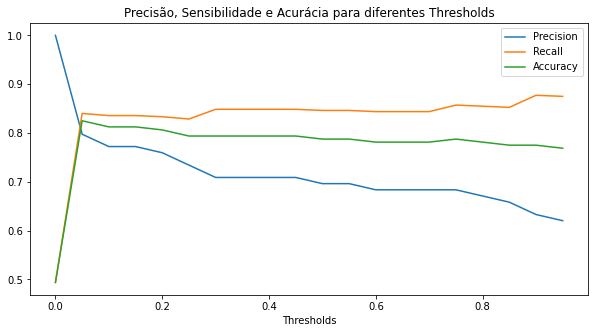

In [24]:
 precisions, recalls, accuracy = precision_recall_accuracy_curve(predict, y)
plot_precision_recall_accuracy_curve(precisions, recalls, accuracy)

In [29]:
best_metrics(threshold = 0.15, predict = predict, y = y)

Matriz de Confusão:
 [[69 18]
 [12 61]]
Acurácia: 0.8125
Precisão 0.7721518987341772
Sensibilidade: 0.8356164383561644
F1_Score: 0.8026315789473685


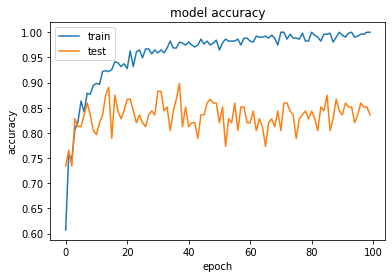

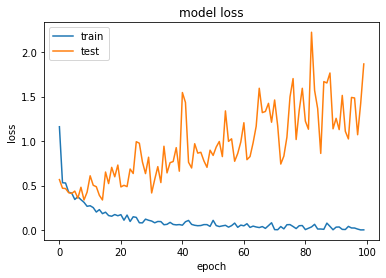

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model-accuracy')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model-loss')